In [2]:
# Dev Singh, Grayson Pacourek, and Shawn Coutinho
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv('BostonHousing.csv',names=column_names)
df.columns = df.iloc[0] 
data = df[1:]

In [3]:
data = data.apply(pd.to_numeric)
data.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


<AxesSubplot:xlabel='0', ylabel='0'>

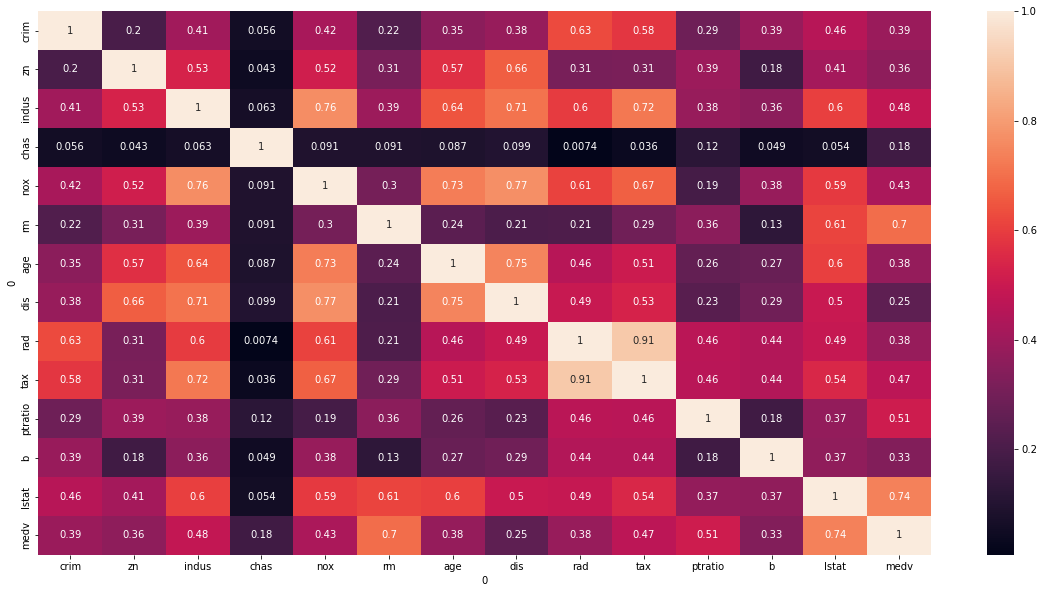

In [4]:
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr().abs(), annot=True)

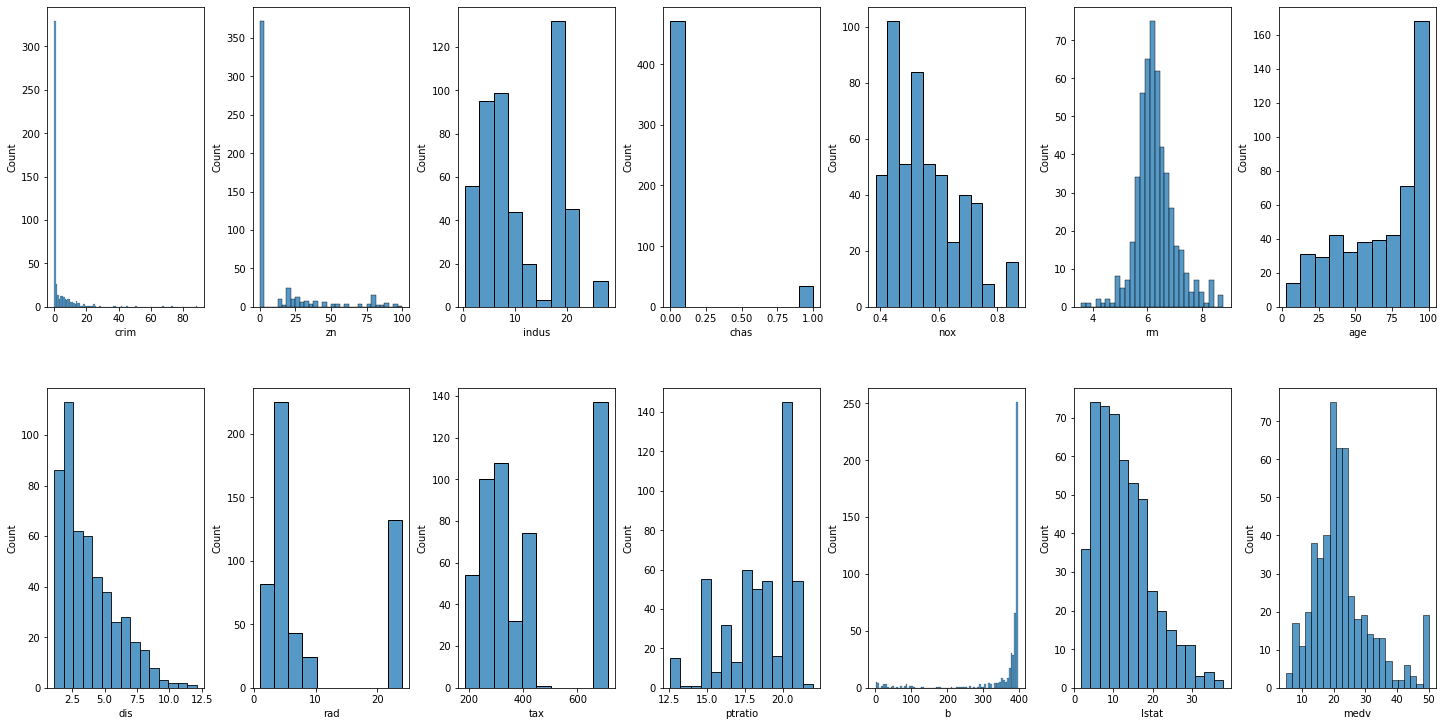

In [5]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.histplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

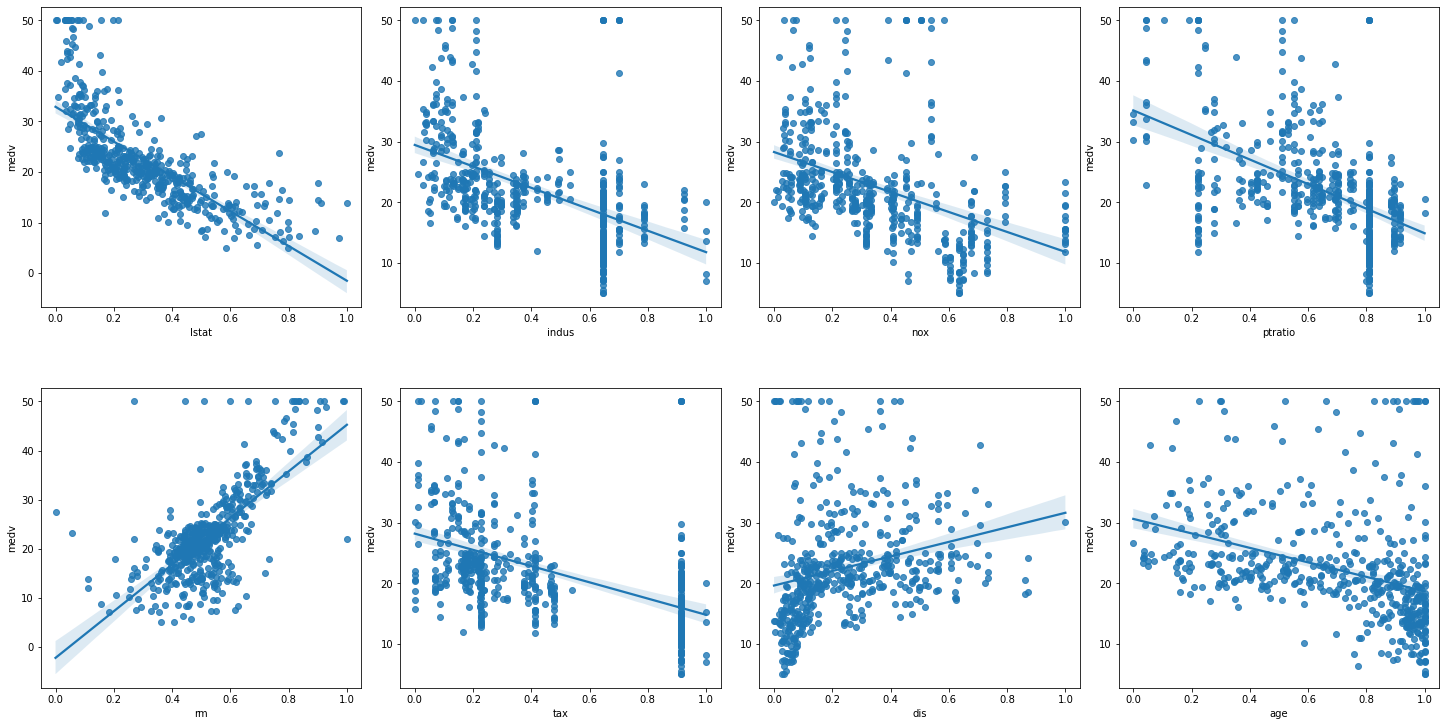

In [6]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
cols = ['lstat', 'indus', 'nox', 'ptratio', 'rm', 'tax', 'dis', 'age'] # high corr cols
x = data.loc[:,cols]
y = data['medv']
x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=cols)
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for i, k in enumerate(cols):
    sns.regplot(y=y, x=x[k], ax=axs[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)


In [7]:
y =  np.log1p(y)
for col in x.columns:
    if np.abs(x[col].skew()) > 0.3:
        x[col] = np.log1p(x[col])

In [8]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np

l_regression = linear_model.LinearRegression()
kf = KFold(n_splits=10) # k fold dataset since not enough data
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scores = cross_val_score(l_regression, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
print("LinReg MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

scores_map = {}
scores_map['LinearRegression'] = scores

LinReg MSE: -0.05 (+/- 0.06)


In [9]:
from sklearn.tree import DecisionTreeRegressor

desc_tr = DecisionTreeRegressor(max_depth=5)
#grid_sv = GridSearchCV(desc_tr, cv=kf, param_grid={"max_depth" : [1, 2, 3, 4, 5, 6, 7]}, scoring='neg_mean_squared_error')
#grid_sv.fit(x_scaled, y)
#print("Best classifier :", grid_sv.best_estimator_)
scores = cross_val_score(desc_tr, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['DecisionTreeRegressor'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

MSE: -0.06 (+/- 0.05)


In [10]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=7)
scores = cross_val_score(knn, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['KNeighborsRegressor'] = scores
print("KNN Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

KNN Accuracy: -0.05 (+/- 0.04)


In [11]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(alpha=0.9,learning_rate=0.075, max_depth=2, min_samples_leaf=5, min_samples_split=2, n_estimators=100, random_state=30)
scores = cross_val_score(gbr, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['GradientBoostingRegressor'] = scores
print("Gradient-Based MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))


Gradient-Based MSE: -0.03 (+/- 0.03)
